In [1]:
import sys, os
import json, pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import time as pytime
import statsmodels.tsa.stattools as tsas
import ruptures as rpt
sys.path.append('../..')
import InsanallyLabEphysTools as ilep
from scipy.stats import gaussian_kde, sem, ttest_ind, ttest_rel, norm, mannwhitneyu, linregress, wilcoxon
from tqdm import tqdm
from types import SimpleNamespace
from sklearn import linear_model
from sklearn.model_selection import KFold
import seaborn as sns
import traceback
from itertools import product
from brokenaxes import brokenaxes
import pingouin as pg
import colorsys

plt.rcParams['legend.fontsize'] = 'small'
plt.rcParams['axes.labelsize'] = 'medium'
plt.rcParams['axes.formatter.limits'] = [-2,3]
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['figure.dpi'] = '150'

#Set global font parameters
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
#Set font type to TrueType for compatibility
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

TARGET_COLOR = '#ff3654'
NONTARGET_COLOR = '#5776ff'

CR_COLOR = '#808080'
NCR_COLOR = '#FF767C'
CNO_COLOR = '#00BFFF'
SWITCH_COLOR = '#B07A3B'
LASER_COLOR = '#3375E9'
GOOD_GREY = '#969696'
GOOD_GREEN = '#32A852'
NCR_COLOR_DESAT = '#D98C90'
CR_COLOR_DESAT = '#A0A0A0'
NCR_CR_cmap = mpl.colors.LinearSegmentedColormap.from_list('NCR-CR color map', [NCR_COLOR, CR_COLOR], N=1000)
PHASE_COLORS = ['#DEB9E0','#B78AB9','#906D92','#ABC5E8','#869BB7','#5E6C80']#,'#6ded94','#50d979','#36bf5f']

dualanimalnames = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_67','BS_70','BS_72','BS_87','BS_108']
danimals = ['DS_15','DS_19','DS_24','DS_27','DS_28']

retroanimals = ['PB_86','BS_86','PB_92','BS_92','BS_100','BS_103','BS_111','BS_119','BS_123','BS_128','BS_131','BS_139','BS_163','BS_165']
did_learn = ['BS_92','BS_103','BS_111','BS_179']
did_not_learn = ['BS_86','BS_100','BS_119','BS_123','BS_128','BS_131','BS_163','BS_174']
indeterminate = ['BS_139','BS_165','BS_191','BS_192']


#BS_59
dualanimalnames = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_67','BS_70','BS_72','BS_87','BS_108']#,'DS_15','DS_19']
opsinanimalnames = ['BS_86','BS_92','BS_100','BS_103','BS_111','BS_119','BS_123','BS_128','BS_131','BS_139','BS_163','BS_165','BS_174','BS_179','BS_191','BS_192']
tuninganimalnames = ['BS_173','BS_175','BS_187','BS_188','BS_213','BS_214','TH_217','AE_235','AE_236','TH_237']
unuseddualanimals = ['BS_78']
danimals = ['DS_15','DS_19','DS_24','DS_27','DS_28','DS_16','DS_17','DS_22','DS_13','DS_23']

#act_directory = 'D:\\Analysis_Cache_archived_Oct_27_2022'
act_directory = '..\\..\\Data\\Analysis_Cache'#'C:\\Users\insan\\Desktop\\Analysis_Cache_Aug23'
beh_directory = '..\\..\\Data\\Behavioor'

stim25sdecodingfilename = 'D:\\stimdecoding_25s.csv'
stim25sopsinondecodingfilename = 'D:\\stimdecoding_25s_opsin_on.csv'
stim25sopsinoffdecodingfilename = 'D:\\stimdecoding_25s_opsin_off.csv'

current_version = 1 #June 22nd, 2023
current_version = 2 #July 11th, 2023
current_version = 3 #July 21th, 2023
current_version = 4 #July 31th, 2023
current_version = 5 #Aug 2nd, 2023
current_version = 6 #Aug 12th, 2023
current_version = 7 #Nov 6th, 2023

stdfont = 14
stdyfrac = 0.06

In [2]:
animals = np.concatenate((dualanimalnames,['DS_15','DS_19']))
# animals = ['BS_51','BS_52','BS_56','BS_59','BS_61']

In [3]:
print(animals)

['BS_40' 'BS_41' 'BS_42' 'BS_49' 'BS_50' 'BS_51' 'BS_56' 'BS_59' 'BS_67'
 'BS_70' 'BS_72' 'BS_87' 'BS_108' 'DS_15' 'DS_19']


In [4]:
animalBehaviors = ilep.getAllBehavior(beh_directory)

Fetching files for BS_51
Fetching files for BS_52
Fetching files for BS_56
Fetching files for BS_59
Fetching files for BS_61
Fetching files for BS_86
Fetching files for BS_92
Fetching files for BS_100
Fetching files for BS_103
Fetching files for BS_111
Fetching files for BS_119
Fetching files for BS_123
Fetching files for BS_128
Fetching files for BS_131
Fetching files for BS_139
Fetching files for BS_163
Fetching files for BS_165
Fetching files for BS_174
Fetching files for BS_179
Fetching files for BS_191
Fetching files for BS_192
Fetching files for BS_33
Fetching files for BS_67
Fetching files for BS_73
Fetching files for BS_78
Fetching files for BS_108
Fetching files for BS_40
Fetching files for BS_41
Fetching files for BS_42
Fetching files for BS_49
Fetching files for BS_50
Fetching files for BS_70
Fetching files for BS_72
Fetching files for BS_83
Fetching files for BS_85
Fetching files for BS_87
Fetching files for BS_95
Fetching files for BS_113
Fetching files for DS_15
Fetching 

C:\Users\4thgr\OneDrive\Documents\TothSidleck2024\Notebooks\Revisions\../..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in scalar divide
  pc = (hit+creject)/(hit+miss+falarm+creject)
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy shoul

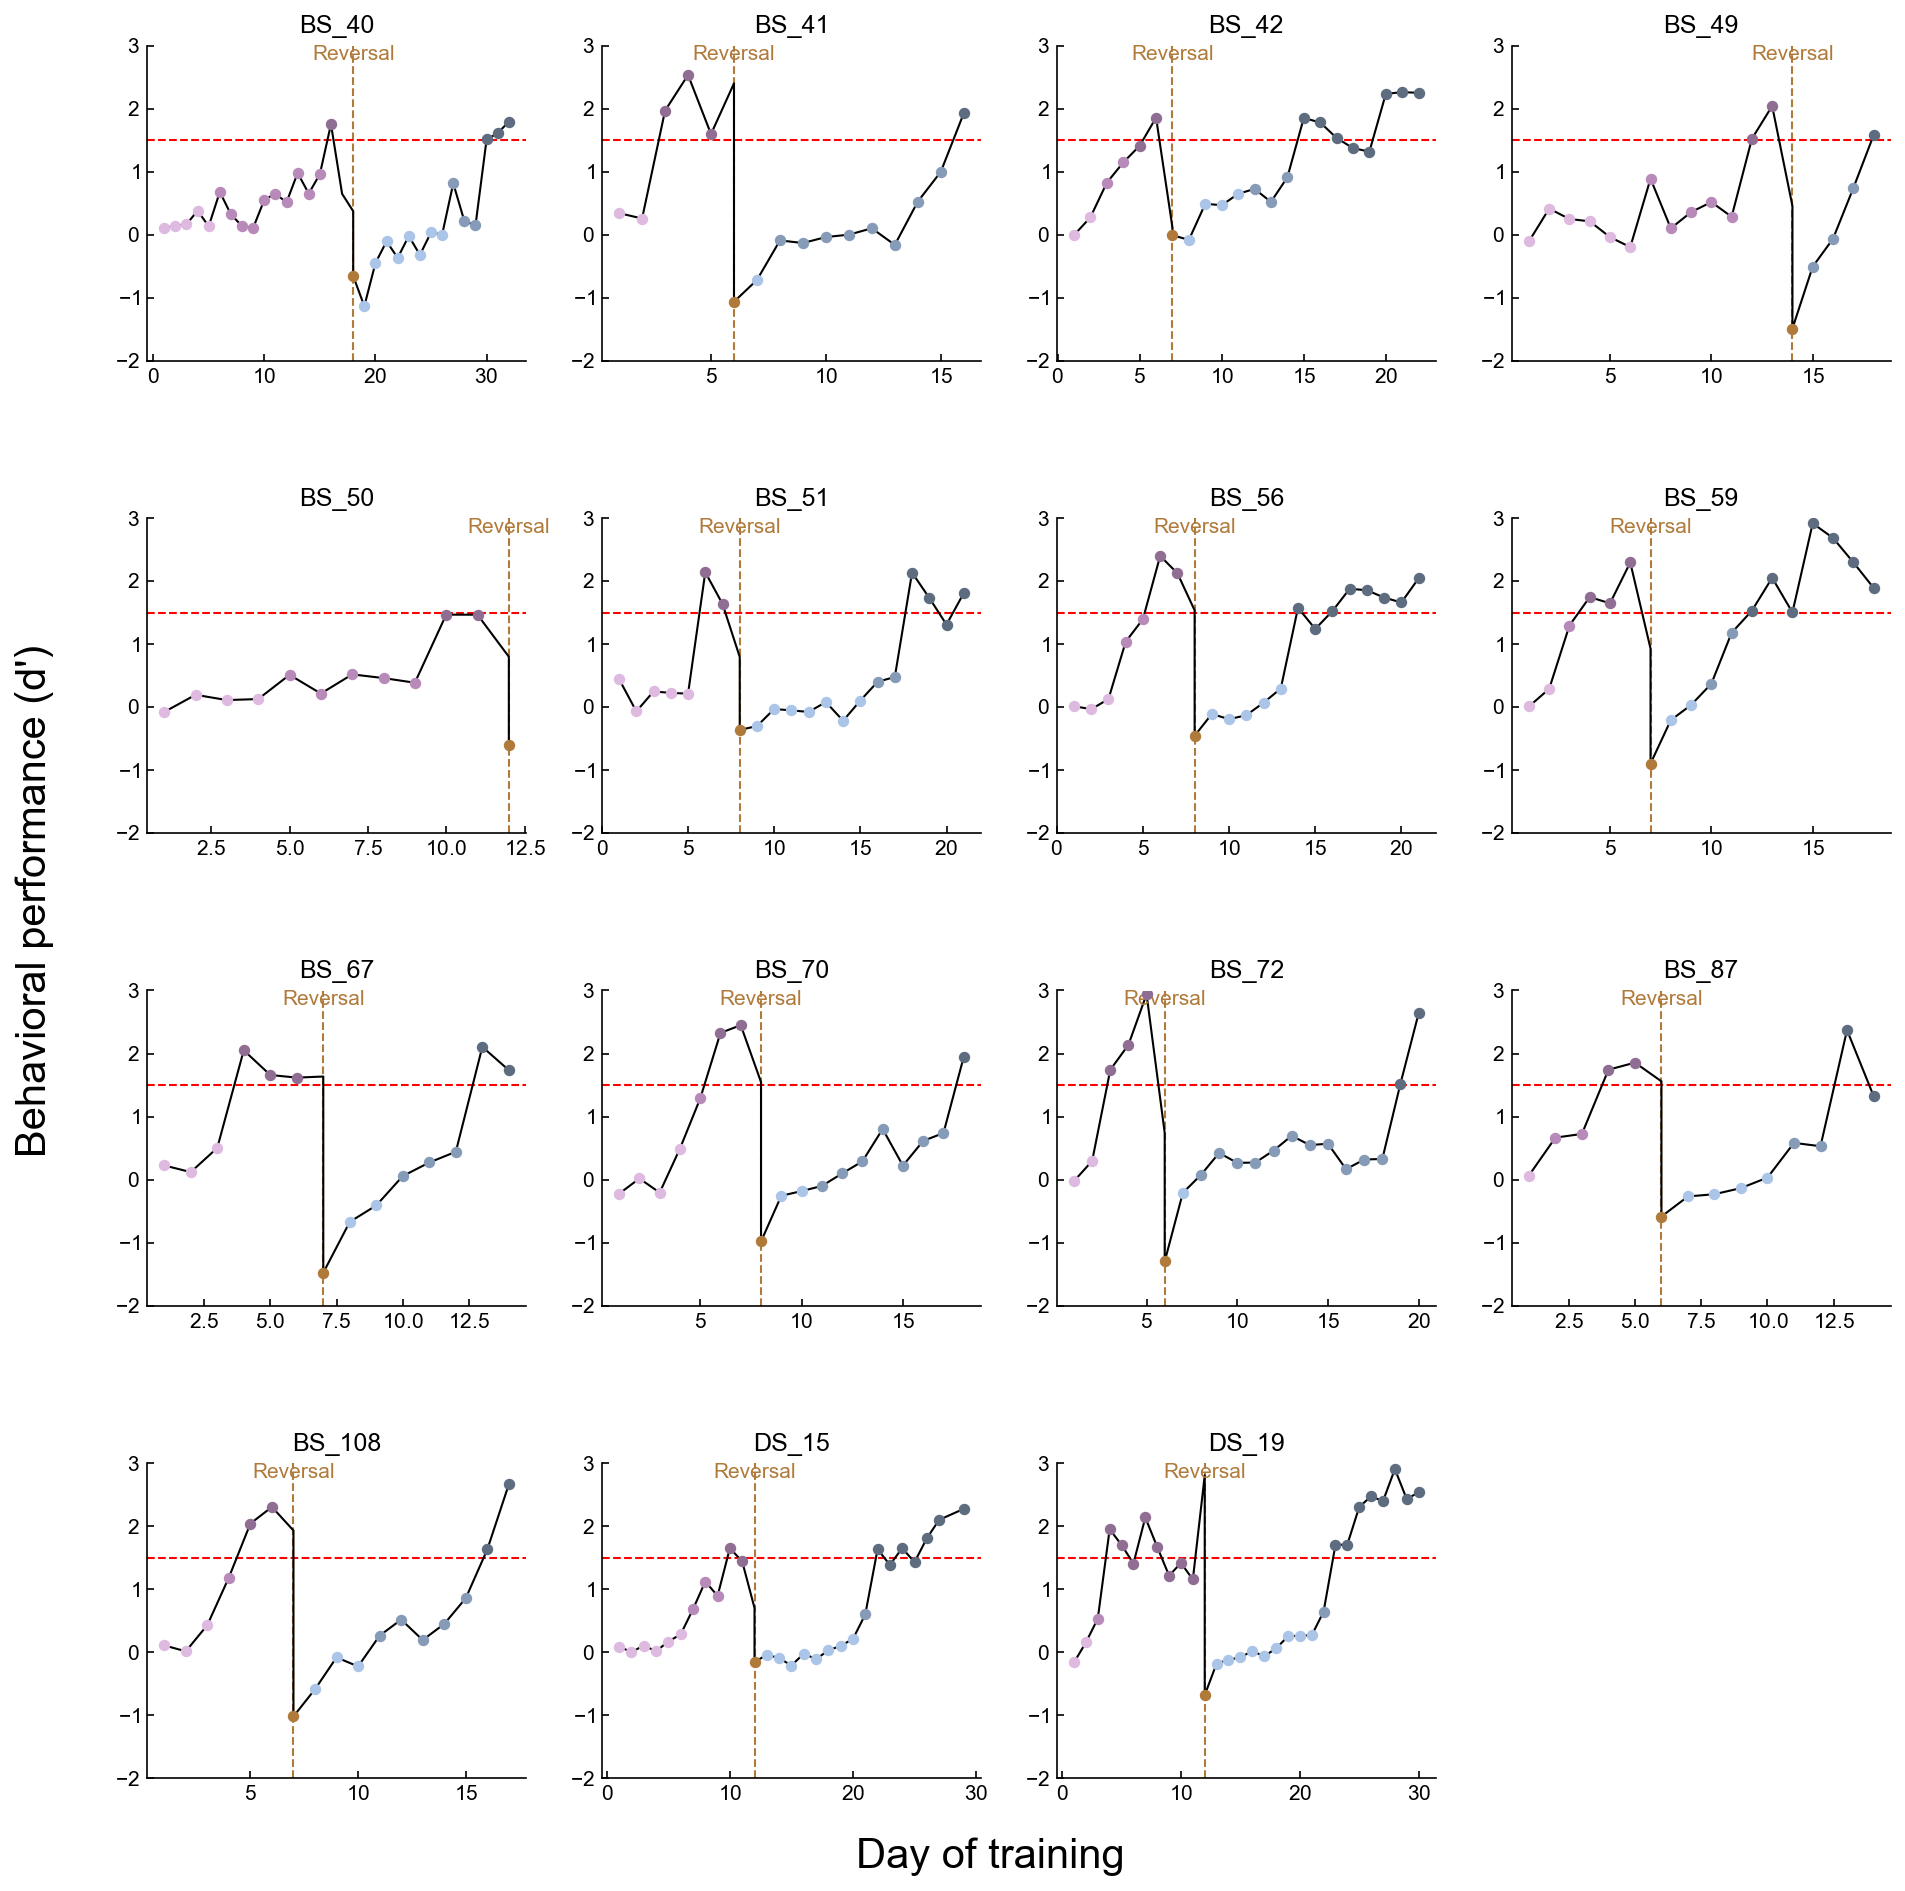

In [5]:
learning_phases,_,_ = ilep.calculateLearningPhasesV2(animals,animalBehaviors,plot=True)
#plt.savefig(os.path.join('D:\\\\TempFigures','All ephys animals learning phases.pdf'),transparent=False,facecolor="white")

In [6]:
EnumSession = []
EnumClust = []
sessions = os.listdir(act_directory)
for session in tqdm(sessions):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    if sessionfile.meta.task in ['passive no behavior']:
        continue
    if sessionfile.meta.task in ['tuning nonreversal','tuning switch','tuning reversal']:
        continue
    if sessionfile.meta.region != 'AC':
        continue
        
    if sessionfile.meta.animal not in animals:
        continue
    
    if sessionfile.meta.animal == 'BS_59':
        print('A')
    
#     EnumSession.append(session)
    for clust in sessionfile.clusters.good:
        EnumSession.append(session)
        EnumClust.append(clust)

100%|██████████| 740/740 [00:13<00:00, 54.24it/s] 


In [7]:
EILphases = np.full_like(EnumSession,np.nan)
error_animals = []

for idx,session in enumerate(tqdm(EnumSession)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    try:
        animal = sessionfile.meta.animal
        day = sessionfile.meta.day_of_training
        
        if sessionfile.meta.task in ['switch','opto switch','tuning switch']:
            EILphases[idx] = 'switch'

        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal'] and day in learning_phases[animal].pre_early_days:
            EILphases[idx] = 'pre early'
        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal']  and day in learning_phases[animal].pre_late_days:
            EILphases[idx] = 'pre late'
        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal'] and day in learning_phases[animal].pre_expert_days:
            EILphases[idx] = 'pre expert'

        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal']  and day in learning_phases[animal].post_early_days:
            EILphases[idx] = 'post early'
        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal']  and day in learning_phases[animal].post_late_days:
            EILphases[idx] = 'post late'
        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal']  and day in learning_phases[animal].post_expert_days:
            EILphases[idx] = 'post expert'
    except Exception as e:
        #print(ilep.generateDateString(sessionfile))
        error_animals.append(sessionfile.meta.animal)
        pass
                             
error_animals = np.unique(error_animals)
print('errors for: '+str(error_animals))

100%|██████████| 1829/1829 [01:06<00:00, 27.59it/s]

errors for: []


In [8]:
cellstouseFR = 'all cells'
#cellstouseFR = 'task encoders'

animals_list = []
sessions_list = []
cluster_ID_list = []
learning_phase_list = []
FRmod_list = []

for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    #Currently not active as tuning curve animals have not been decoded
    if cellstouseFR == 'task encoders':
        if not np.isfinite(accuracies[idx]) or pvals[idx] > 0.05 or accuracies[idx] < task_encoder_threshold:
            continue
    
    if EILphases[idx] not in ['pre early','pre late','pre expert','post early','post late','post expert']:
        continue

    if EILphases[idx] not in ['pre expert','post expert'] and sessionfile.meta.animal in ['DS_15','DS_19']:
        continue
        
    try:
        FRmod = sessionfile.responsiveness[clust]['correct'].FRmodulation
    except Exception as e:
        FRmod = np.nan
        print(e)

    animals_list.append(sessionfile.meta.animal)
    sessions_list.append(session)
    cluster_ID_list.append(clust)
    learning_phase_list.append(EILphases[idx])
    FRmod_list.append(FRmod)

1829it [01:34, 19.31it/s]


In [9]:
df_dict = dict()
df_dict['animal'] = animals_list
df_dict['session'] = sessions_list
df_dict['cluster ID'] = cluster_ID_list
df_dict['learning phase'] = learning_phase_list
df_dict['FR modulation'] = FRmod_list
df = pd.DataFrame(df_dict)

In [10]:
df

,animal,session,cluster ID,learning phase,FR modulation
0,BS_108,BS_108_1_AC.pickle,2,pre expert,11.560284
1,BS_108,BS_108_1_AC.pickle,8,pre expert,25.085911
2,BS_108,BS_108_1_AC.pickle,9,pre expert,18.419244
3,BS_108,BS_108_1_AC.pickle,14,pre expert,14.468085
4,BS_108,BS_108_1_AC.pickle,34,pre expert,20.000000
...,...,...,...,...,...
1358,DS_19,DS_19_1_AC.pickle,96,pre expert,3.247232
1359,DS_19,DS_19_1_AC.pickle,106,pre expert,1.997677
1360,DS_19,DS_19_20_AC.pickle,7,post expert,4.731183
1361,DS_19,DS_19_20_AC.pickle,8,post expert,3.182796


In [11]:
np.sum(np.isfinite(df['FR modulation']))

1327

In [12]:
FRmod_preearly = []
FRmod_prelate = []
FRmod_preexpert = []
FRmod_postearly = []
FRmod_postlate = []
FRmod_postexpert = []

for row in df.iloc:
    if row['learning phase'] == 'pre early':
        FRmod_preearly.append(row['FR modulation'])
    if row['learning phase'] == 'pre late':
        FRmod_prelate.append(row['FR modulation'])
    if row['learning phase'] == 'pre expert':
        FRmod_preexpert.append(row['FR modulation'])
        
    if row['learning phase'] == 'post early':
        FRmod_postearly.append(row['FR modulation'])
    if row['learning phase'] == 'post late':
        FRmod_postlate.append(row['FR modulation'])
    if row['learning phase'] == 'post expert':
        FRmod_postexpert.append(row['FR modulation'])

FRmod_preearly = np.array(FRmod_preearly)
FRmod_prelate = np.array(FRmod_prelate)
FRmod_preexpert = np.array(FRmod_preexpert)
FRmod_postearly = np.array(FRmod_postearly)
FRmod_postlate = np.array(FRmod_postlate)
FRmod_postexpert = np.array(FRmod_postexpert)

C:\Users\4thgr\AppData\Local\Temp\ipykernel_42784\1618522114.py:36: RuntimeWarning: divide by zero encountered in log10
  X,_ = ilep.violin(np.concatenate(X),np.log10(np.concatenate(data)),width=0.75,minjitter=0.075)


3.4647512636339473
3.115942028985507
3.7837837837837838
3.200519730962796
2.0717787959167264
2.7826086956521743


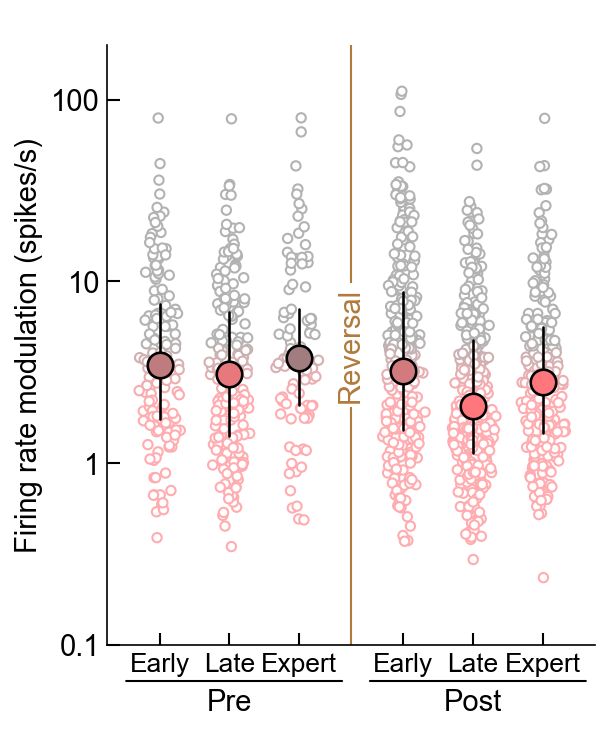

In [13]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(3.25, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0.25

################################################################################################################

size = 20
summary_size=150
summary_width=1.25#0.75

mn = 3.5
spread = 2.5
# colors = NCR_CR_cmap( (Y-(mn-spread/2))/ (spread) )
    
###
    
FRmod_baseline_median = 3.5
data = [FRmod_preearly,FRmod_prelate,FRmod_preexpert,FRmod_postearly,FRmod_postlate,FRmod_postexpert]
labels = ['Early','Late','Expert','Early','Late','Expert']
numCon = len(data)

###
X = [np.ones(len(l))*idx + polarity*switch_offset for idx,(l,polarity) in enumerate(zip(data,[-1,-1,-1,1,1,1]))]
_,Y = ilep.violin(np.concatenate(X),np.concatenate(data),width=0.75,minjitter=0.075)
X,_ = ilep.violin(np.concatenate(X),np.log10(np.concatenate(data)),width=0.75,minjitter=0.075)
colors = NCR_CR_cmap( (Y-(mn-spread/2))/ (spread) )

ax.scatter(X, Y, s=size, ec=colors, fc='white', lw=1,zorder=-10,clip_on=False)
ax.set_yscale('log',subs=[])

#Plot summary
for idx,(column,polarity) in enumerate(zip(data,[-1,-1,-1,1,1,1])):
    column = ilep.rmnan(column)
    percentCR = np.nanmean(np.greater(column,FRmod_baseline_median))*100
    
    eye_color= NCR_CR_cmap((percentCR-40)/20)
    border_color = 'k'#NCR_CR_cmap((percentCR-40)/20)  
#     r,g,b = mpl.colors.to_rgb(eye_color)
#     h,l,s = colorsys.rgb_to_hls(r,g,b)
    
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
#     median = np.mean(column)
#     Q1 = median - sem(column)
#     Q1 = median + sem(column)

    print(median)
    
    ax.scatter([idx+polarity*switch_offset], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx+polarity*switch_offset, idx+polarity*switch_offset], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')


################################################################################################################
labels = ['Early','Late','Expert','Early','Late','Expert']

ax.set_ylim([0.1,200])
ax.set_yticks([0.1,1,10,100])
ax.set_yticklabels(['0.1','1','10','100'])
ylab = ax.set_ylabel('Firing rate modulation (spikes/s)')

ax.set_xlim([-0.75-switch_offset,5.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax.set_xticklabels(labels)
# xlab = ax.set_xlabel('Example X label')

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac,log=True)
t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.03, -stdyfrac), xycoords='axes fraction', xytext=(0.49, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -stdyfrac), xycoords='axes fraction', xytext=(0.99, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

Y = np.mean(ax.get_ylim())
Y = 10**np.mean(np.log10(ax.get_ylim()))
t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
ax.plot([2.5]*2,[ax.get_ylim()[0],Y*0.45],lw=1,color=SWITCH_COLOR)
ax.plot([2.5]*2,[ax.get_ylim()[1],Y/0.45],lw=1,color=SWITCH_COLOR)

ax.fill_between(ax.get_xlim(),[ax.get_ylim()[0]]*2,[ax.get_ylim()[1]*2]*2,color='white',alpha=0.4,zorder=-5,clip_on=False)

ttl = ax.set_title(' ')
artists = [ylab,t1,t2,ttl]
fig.savefig(os.path.join('C:\\\\Users','4thgr','Downloads','3a correct V'+str(current_version)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

In [14]:
#Use this. Post is normal, Pre is not
data_dec = SimpleNamespace()
data_dec.preearly = np.abs(FRmod_preearly)
data_dec.prelate = np.abs(FRmod_prelate)
data_dec.preexpert = np.abs(FRmod_preexpert)
data_dec.postearly = np.abs(FRmod_postearly)
data_dec.postlate = np.abs(FRmod_postlate)
data_dec.postexpert = np.abs(FRmod_postexpert)
ilep.mannwhitneycompareall(data_dec)
pass

pre-early   n = 148
pre-late    n = 187
pre-expert  n = 97
post-early  n = 306
post-late   n = 342
post-expert n = 247
pre-early  to pre-late   : 0.14733161853406365
pre-late   to pre-expert : 0.07867770882801145
pre-early  to pre-expert : 0.42691507705320386
post-early to post-late  : 2.3988221493688734e-05
post-late  to post-expert: 0.03110106901757567
post-early to post-expert: 0.07978653733469655
